In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# Calculates the yyyy,mm,dd from today.
# number_of_days - The differental in days.  Can be positive or negative
def calculate_date(from_date, number_of_days):
    try:
        dt_from = dt.datetime.strptime(from_date, '%Y-%m-%d')
        new_date = dt_from + dt.timedelta(days=number_of_days)
        new_date = new_date.strftime('%Y-%m-%d')
    except ValueError as err:
        print("Date value out of range.")
    return new_date

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
inspector = inspect(engine)

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [12]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x179bdb20e48>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [13]:
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [14]:
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data

Start date: 2016-08-23, End date: 2017-08-23


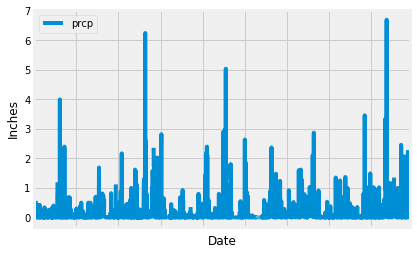

In [16]:

precip_query = session.query(Measurement.date, Measurement.prcp).\
    order_by(Measurement.date.desc())
end_date = precip_query.first()[0]
start_date =  calculate_date(end_date, -365)
print(f'Start date: {start_date}, End date: {end_date}')
precip_query = precip_query.filter(Measurement.date <= end_date, Measurement.date >= start_date).\
                            order_by (Measurement.date)

precip_df = pd.DataFrame(precip_query[:], columns=['date', 'prcp'])

axis = precip_df.plot(kind="line", y='prcp')
plt.xlabel('Date')
plt.ylabel("Inches")
axis.axes.get_xaxis().set_ticklabels([])
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
# Design a query to show how many stations are available in this dataset?
# Should be 9
station_count = session.query(Measurement.station).distinct().count()
station_count

9

In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_query = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc())
most_active_query.all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Station USC00519281 has the most observations.

In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
## [(54.0, 85.0, 71.66378066378067)]
station_id = most_active_query.first()[0]
station_query = session.query(func.min(Measurement.tobs), 
                              func.max(Measurement.tobs), 
                              func.avg(Measurement.tobs)).\
                        filter(Measurement.station == station_id)

station_query.all()

[(54.0, 85.0, 71.66378066378067)]

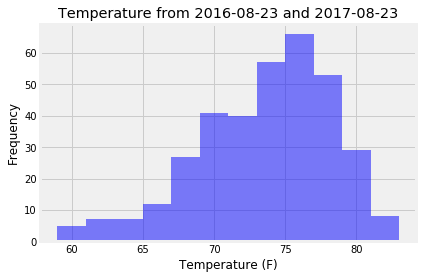

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_temps_query = session.query(Measurement.tobs).\
                    filter(Measurement.station == station_id)
most_active_temps_query = most_active_temps_query.\
                    filter(Measurement.date <= end_date, Measurement.date >= start_date).\
                    order_by (Measurement.date)

df_temps = pd.DataFrame(most_active_temps_query[:], columns=['temp'])
data = df_temps['temp'].tolist()
num_bins = 12

n, bins, patches = plt.hist(data, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.title(f'Temperature from {start_date} and {end_date}')

plt.show()

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# 62.0 68.36585365853658 74.0
vacation_start = '2013-10-08'
start_date = calculate_date(vacation_start, -365)
end_date = calculate_date(start_date, 14)
trip_list = calc_temps(start_date, end_date)
trip_list

[(67.0, 75.3076923076923, 82.0)]

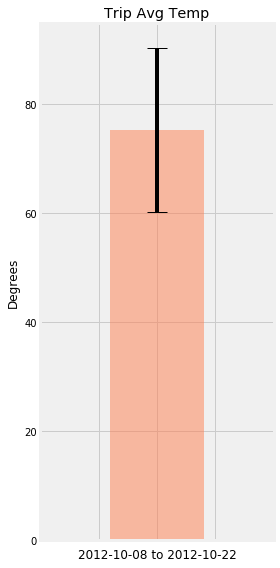

In [25]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

x_pos = len(trip_list)
mean = trip_list[0][1]
erro = trip_list[0][2] - trip_list[0][0]

fig, ax = plt.subplots(figsize=(4,8))
ax.bar(x_pos, mean, yerr=erro, align='center', alpha=0.5, ecolor='black', capsize=10, facecolor='coral')
ax.set_xlabel(f'{start_date} to {end_date}')
ax.set_ylabel('Degrees')
#ax.set_xticks(x_pos)
ax.set_xticklabels('')
ax.set_title('Trip Avg Temp')
ax.yaxis.grid(True)
plt.xlim(0,2)
plt.tight_layout()

plt.show()

In [26]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

In [27]:
vacation_start = '2013-06-08'
start_date = calculate_date(vacation_start, -365)
end_date = calculate_date(start_date, 14)

M = Measurement
S = Station
sel = [S.station, S.name, S. latitude, S.longitude, S.elevation, func.sum(M.prcp), M.date]
rainfall_query = session.query(*sel).join(M, S.station == M.station).\
                        filter(M.date >= start_date).filter(M.date <= end_date).\
                        group_by(S.name).\
                        order_by(func.sum(M.prcp).desc())

rainfall_query.all()

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  3.95,
  '2012-06-08'),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  1.2200000000000002,
  '2012-06-08'),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.52,
  '2012-06-08'),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  0.39,
  '2012-06-08'),
 ('USC00517948',
  'PEARL CITY, HI US',
  21.3934,
  -157.9751,
  11.9,
  0.32,
  '2012-06-08'),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.09,
  '2012-06-21'),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  0.05,
  '2012-06-08'),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  0.0,
  '2012-06-08'),
 ('USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  21.4992,
  -158.0111,
  306.6,
  None,
  '2012-06-14')]

## Optional Challenge Assignment

In [28]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [29]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date

# Use start_date and end_date from above.

date_range = np.arange(start_date, end_date, dtype='datetime64[D]')
date_list = [str(adate)[5:10] for adate in date_range]
normals = [daily_normals(dt)[0] for dt in date_list]
normals

[(70.0, 75.58620689655173, 81.0),
 (69.0, 75.15254237288136, 81.0),
 (68.0, 75.14285714285714, 81.0),
 (69.0, 76.01960784313725, 84.0),
 (66.0, 75.66666666666667, 83.0),
 (68.0, 75.66666666666667, 81.0),
 (69.0, 75.62711864406779, 81.0),
 (67.0, 75.40350877192982, 81.0),
 (69.0, 75.41379310344827, 81.0),
 (68.0, 74.59322033898304, 81.0),
 (69.0, 74.60344827586206, 80.0),
 (70.0, 75.44067796610169, 82.0),
 (68.0, 73.96491228070175, 85.0),
 (68.0, 74.75862068965517, 82.0)]

In [30]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df_normals = pd.DataFrame(normals, columns =['tmin', 'tave', 'tmax'], index=date_range) 
df_normals.index.rename('date', inplace=True)
df_normals


,tmin,tave,tmax
date,,,
2012-06-08,70.0,75.586207,81.0
2012-06-09,69.0,75.152542,81.0
2012-06-10,68.0,75.142857,81.0
2012-06-11,69.0,76.019608,84.0
2012-06-12,66.0,75.666667,83.0
2012-06-13,68.0,75.666667,81.0
2012-06-14,69.0,75.627119,81.0
2012-06-15,67.0,75.403509,81.0
2012-06-16,69.0,75.413793,81.0


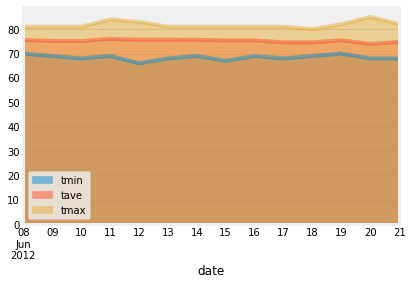

In [31]:
# Plot the daily normals as an area plot with `stacked=False`
df_normals.plot.area(stacked=False)